In [42]:
from functools import partial
from typing import Any, Optional

import torch
import torch.nn as nn

from tqdm import tqdm

In [43]:
import numpy as np
import pandas as pd
import os
from skimage.io import imread
import cv2 as cv
from pathlib import Path
import random
from shutil import copyfile, rmtree
import json
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset
import torch.nn as nn
from torchvision import transforms
from PIL import Image
from torch import nn, optim
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler

In [44]:
# root_path = "/content/drive/MyDrive/sw_data/"
root_path = "."

dir = f"{root_path}/train_test_sw/train_sw/"
print(os.listdir(dir))

['Beech', 'Gardenia', 'Lemon', 'Mean', 'Tomato']


In [45]:
test_labels_path = f"{root_path}/train_test_sw/test_labels.json"
test_labels = pd.read_json(test_labels_path)
test_labels["path"] = test_labels.filename.map(
    lambda filename: f"{root_path}/train_test_sw/test_sw/{filename}"
)
test_labels

,filename,value,path
0,Beech1frame0000022.png,Beech,./train_test_sw/test_sw/Beech1frame0000022.png
1,Beech1frame0000026.png,Beech,./train_test_sw/test_sw/Beech1frame0000026.png
2,Beech1frame0000027.png,Beech,./train_test_sw/test_sw/Beech1frame0000027.png
3,Beech1frame0000044.png,Beech,./train_test_sw/test_sw/Beech1frame0000044.png
4,Beech1frame0000045.png,Beech,./train_test_sw/test_sw/Beech1frame0000045.png
...,...,...,...
254,Tomato5frame0000300.png,Tomato,./train_test_sw/test_sw/Tomato5frame0000300.png
255,Tomato5frame0000309.png,Tomato,./train_test_sw/test_sw/Tomato5frame0000309.png
256,Tomato5frame0000311.png,Tomato,./train_test_sw/test_sw/Tomato5frame0000311.png
257,Tomato5frame0000313.png,Tomato,./train_test_sw/test_sw/Tomato5frame0000313.png


In [46]:
train_dirs = os.listdir(f"{root_path}/train_test_sw/train_sw")

train_labels = pd.DataFrame()

for d in train_dirs:
    for f in os.listdir(f"{root_path}/train_test_sw/train_sw/{d}"):
        df_dict = pd.DataFrame(
            [
                {
                    "filename": f,
                    "path": f"{root_path}/train_test_sw/train_sw/{d}/{f}",
                    "value": d,
                }
            ]
        )
        # print(df_dict)
        train_labels = pd.concat([train_labels, df_dict], ignore_index=True)

train_labels


,filename,path,value
0,Beech1frame0000012.png,./train_test_sw/train_sw/Beech/Beech1frame0000...,Beech
1,Beech1frame0000013.png,./train_test_sw/train_sw/Beech/Beech1frame0000...,Beech
2,Beech1frame0000014.png,./train_test_sw/train_sw/Beech/Beech1frame0000...,Beech
3,Beech1frame0000015.png,./train_test_sw/train_sw/Beech/Beech1frame0000...,Beech
4,Beech1frame0000016.png,./train_test_sw/train_sw/Beech/Beech1frame0000...,Beech
...,...,...,...
2870,Tomato5frameModifedModifed0000312.png,./train_test_sw/train_sw/Tomato/Tomato5frameMo...,Tomato
2871,Tomato5frameModifedModifed0000315.png,./train_test_sw/train_sw/Tomato/Tomato5frameMo...,Tomato
2872,Tomato5frameModifedModifed0000316.png,./train_test_sw/train_sw/Tomato/Tomato5frameMo...,Tomato
2873,Tomato5frameModifedModifed0000317.png,./train_test_sw/train_sw/Tomato/Tomato5frameMo...,Tomato


In [64]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 192, kernel_size=5,padding=2),
            nn.BatchNorm2d(192),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.2),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.2),
            nn.Linear(4096, num_classes),
        )
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.avgpool(x)
        x = x.reshape(x.size(0), -1)
        x = self.classifier(x)
        return x

In [65]:
from torch.utils.data import Dataset
class CustomImageDataset(Dataset):
    def __init__(self, df, transform=None, target_transform=None):
        self.img_labels = df["value"]
        self.img_dir = df["path"]
        self.transform = transform
        self.target_transform = target_transform
        self.labels_dict = {label: i for i, label in enumerate(df["value"].unique())}

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = self.img_dir[idx]
        image = Image.open(img_path)
        label = self.img_labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image[:3], self.labels_dict[label]

In [66]:
# Batch size : How many images are used to calculate the gradient
batch_size = 32
number_of_classes = 5
# Train DataLoader
train_dataset = CustomImageDataset(
    train_labels,
    transform=transforms.Compose(
        [
            transforms.Resize(64),
            # transforms.Normalize(),
            transforms.ToTensor(),
        ]
    ),
)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
# Validation DataLoader
validation_dataset = CustomImageDataset(
    test_labels,
    transform=transforms.Compose(
        [
            transforms.Resize(64),
            # transforms.Normalize(),
            transforms.ToTensor(),
        ]
    ),
)
validation_loader = DataLoader(
    dataset=validation_dataset, batch_size=batch_size, shuffle=False
)

In [67]:
device=torch.device("cuda:0" if torch.cuda.is_available else "cpu")
device

device(type='cuda', index=0)

In [68]:
num_epochs = 100
batch_size = 32
learning_rate = 0.005

model = AlexNet().to(device)


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9) 
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, eta_min=0.00001) 


# Train the model
total_step = len(train_loader)

In [69]:
train_acc = []
train_loss = []

def train(epoch):
  print('\nEpoch : %d'%epoch)
   
  model.train()
 
  running_loss=0
  correct=0
  total=0

  for i, (imgs, labels) in enumerate(train_loader):
    #move tensors to device
    imgs = imgs.to(device)
    labels = labels.to(device)

    #Forward pass
    outputs = model(imgs)
    loss = criterion(outputs, labels)

    #Bacward & opt
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    running_loss += loss.item()

    #
    _, predicted = outputs.max(1)
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()

  loss = running_loss/len(train_loader)
  acc = correct/total

  train_acc.append(acc)
  train_loss.append(loss)
  print('Train Loss: %.3f | Accuracy: %.3f'%(loss, acc))

  scheduler.step()

In [70]:
eval_loss = []
eval_acc = []
 
def test(epoch):
  model.eval()
 
  running_loss=0
  correct=0
  total=0

  with torch.no_grad():
    for imgs, labels in validation_loader:
      imgs = imgs.to(device)
      labels = labels.to(device)
      outputs = model(imgs)

      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()
      del imgs, labels, outputs
    
  test_loss = running_loss/len(validation_loader)
  acc = correct/total

  eval_loss.append(test_loss)
  eval_acc.append(acc)
 
  print('Test Loss: %.3f | Accuracy: %.3f'%(test_loss,acc))

In [61]:
total_step = len(train_loader)

for epoch in range(num_epochs):
    train(epoch)
    test(epoch)


Epoch : 0
Train Loss: 1.578 | Accuracy: 0.277
Test Loss: 0.000 | Accuracy: 0.313

Epoch : 1
Train Loss: 1.469 | Accuracy: 0.319
Test Loss: 0.000 | Accuracy: 0.320

Epoch : 2
Train Loss: 1.435 | Accuracy: 0.347
Test Loss: 0.000 | Accuracy: 0.270

Epoch : 3
Train Loss: 1.303 | Accuracy: 0.387
Test Loss: 0.000 | Accuracy: 0.212

Epoch : 4
Train Loss: 1.230 | Accuracy: 0.419
Test Loss: 0.000 | Accuracy: 0.259

Epoch : 5
Train Loss: 1.174 | Accuracy: 0.447
Test Loss: 0.000 | Accuracy: 0.232

Epoch : 6
Train Loss: 1.092 | Accuracy: 0.493
Test Loss: 0.000 | Accuracy: 0.363

Epoch : 7
Train Loss: 1.067 | Accuracy: 0.498
Test Loss: 0.000 | Accuracy: 0.525

Epoch : 8
Train Loss: 0.977 | Accuracy: 0.545
Test Loss: 0.000 | Accuracy: 0.537

Epoch : 9
Train Loss: 1.244 | Accuracy: 0.437
Test Loss: 0.000 | Accuracy: 0.286

Epoch : 10
Train Loss: 1.241 | Accuracy: 0.432
Test Loss: 0.000 | Accuracy: 0.274

Epoch : 11
Train Loss: 1.134 | Accuracy: 0.488
Test Loss: 0.000 | Accuracy: 0.266

Epoch : 12
Tr

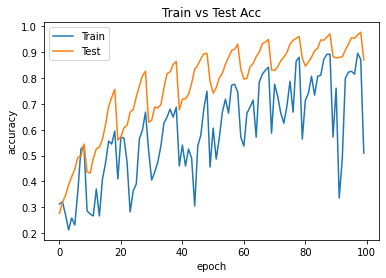

In [63]:
plt.plot(eval_acc)
plt.plot(train_acc)
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(["Train", "Test"])
plt.title("Train vs Test Acc")

plt.show()

In [72]:
total_step = len(train_loader)

for epoch in range(num_epochs):
    train(epoch)
    test(epoch)


Epoch : 0
Train Loss: 2.285 | Accuracy: 0.210
Test Loss: 0.000 | Accuracy: 0.301

Epoch : 1
Train Loss: 1.603 | Accuracy: 0.265
Test Loss: 0.000 | Accuracy: 0.201

Epoch : 2
Train Loss: 1.509 | Accuracy: 0.296
Test Loss: 0.000 | Accuracy: 0.259

Epoch : 3
Train Loss: 1.423 | Accuracy: 0.348
Test Loss: 0.000 | Accuracy: 0.367

Epoch : 4
Train Loss: 1.343 | Accuracy: 0.374
Test Loss: 0.000 | Accuracy: 0.317

Epoch : 5
Train Loss: 1.268 | Accuracy: 0.400
Test Loss: 0.000 | Accuracy: 0.266

Epoch : 6
Train Loss: 1.176 | Accuracy: 0.445
Test Loss: 0.000 | Accuracy: 0.290

Epoch : 7
Train Loss: 1.111 | Accuracy: 0.471
Test Loss: 0.000 | Accuracy: 0.405

Epoch : 8
Train Loss: 1.026 | Accuracy: 0.520
Test Loss: 0.000 | Accuracy: 0.355

Epoch : 9
Train Loss: 0.984 | Accuracy: 0.535
Test Loss: 0.000 | Accuracy: 0.432

Epoch : 10
Train Loss: 1.288 | Accuracy: 0.417
Test Loss: 0.000 | Accuracy: 0.371

Epoch : 11
Train Loss: 1.280 | Accuracy: 0.422
Test Loss: 0.000 | Accuracy: 0.317

Epoch : 12
Tr

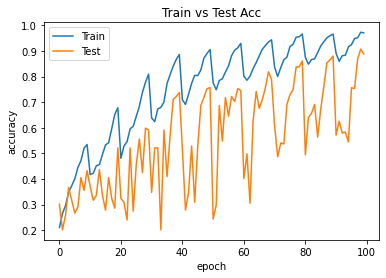

In [75]:
plt.plot(train_acc)
plt.plot(eval_acc)
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(["Train", "Test"])
plt.title("Train vs Test Acc")

plt.show()

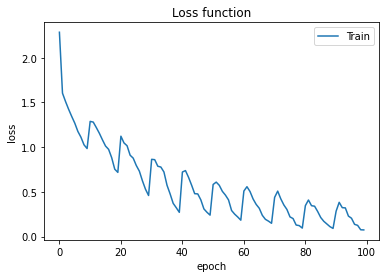

In [74]:
plt.plot(train_loss)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["Train"])
plt.title("Loss function")

plt.show()